In [3]:
source('helpers.R')

In [4]:
prepost <- readRDS("../../../ProcessedData/seurat/annotated_prepost_csf.rds")

In [6]:
df_all <- prepost@meta.data %>%
  filter(Day == "D7") %>%
  mutate(response_status = ifelse(response_status == "responder", "R", "NR")) %>%
  group_by(Patient, response_status, cell_type) %>%
  summarise(n = n(), .groups = "drop")

totals <- df_all %>% group_by(Patient, response_status) %>% summarise(total_cells = sum(n), .groups = "drop")

df <- df_all %>%
  left_join(totals, by = c("Patient", "response_status")) %>%
  mutate(prop = n / total_cells) %>%
  filter(cell_type %in% c("CD4+ CAR T","CD8+ CAR T"))

dfw <- df %>%
  group_by(Patient, response_status) %>%
  summarise(
    cd4 = sum(n[cell_type=="CD4+ CAR T"]),
    cd8 = sum(n[cell_type=="CD8+ CAR T"]),
    .groups = "drop"
  ) %>%
  mutate(ratio = cd8 / cd4)


cmp <- list(c("NR", "R"))
cols <- c(R = "#1F78B4", NR = "#A6CEE3")

df_cd4 <- df %>% filter(cell_type == "CD4+ CAR T")
df_cd8 <- df %>% filter(cell_type == "CD8+ CAR T")

y_cd4   <- max(df_cd4$prop) * 1.05
y_cd8   <- max(df_cd8$prop) * 1.05
y_ratio <- max(dfw$ratio) * 1.05

p_cd4 <- ggplot(df_cd4, aes(response_status, prop, fill = response_status)) +
  geom_boxplot(outlier.shape = NA) +
  geom_point(size=1) + 
  stat_compare_means(comparisons = cmp, method = "wilcox.test", method.args  = list(exact = TRUE),
    label = "p.format", y.position = y_cd4) +
  scale_fill_manual(values = cols) +
  labs(y = "Proportion of CD4+ CAR T", x = NULL) +
  theme_pubr(base_size = 12) +
  theme(legend.position = "none")

p_cd8 <- ggplot(df_cd8, aes(response_status, prop, fill = response_status)) +
  geom_boxplot(outlier.shape = NA) +
  geom_point(size=1) + 
  stat_compare_means(comparisons = cmp, method = "wilcox.test", method.args = list(exact = TRUE),
    label = "p.format", y.position = y_cd8) +
  scale_fill_manual(values = cols) +
  labs(y = "Proportion of CD8+ CAR T", x = NULL) +
  theme_pubr(base_size = 12) +
  theme(legend.position = "none")

p_ratio <- ggplot(dfw, aes(response_status, ratio, fill = response_status)) +
  geom_boxplot(outlier.shape = NA) +
  geom_point(size=1) + 
  stat_compare_means( comparisons = cmp, method = "wilcox.test", method.args  = list(exact = TRUE),
    label = "p.format", y.position = y_ratio) +
  scale_fill_manual(values = cols) +
  labs(y = "CD8  CD4 CAR T ratio", x = NULL) +
  theme_pubr(base_size = 12) +
  theme(legend.position = "none")

final_fig <- p_cd4 + p_cd8 + p_ratio +
  patchwork::plot_layout(ncol = 3) &
  theme(plot.margin = margin(10, 10, 10, 10))

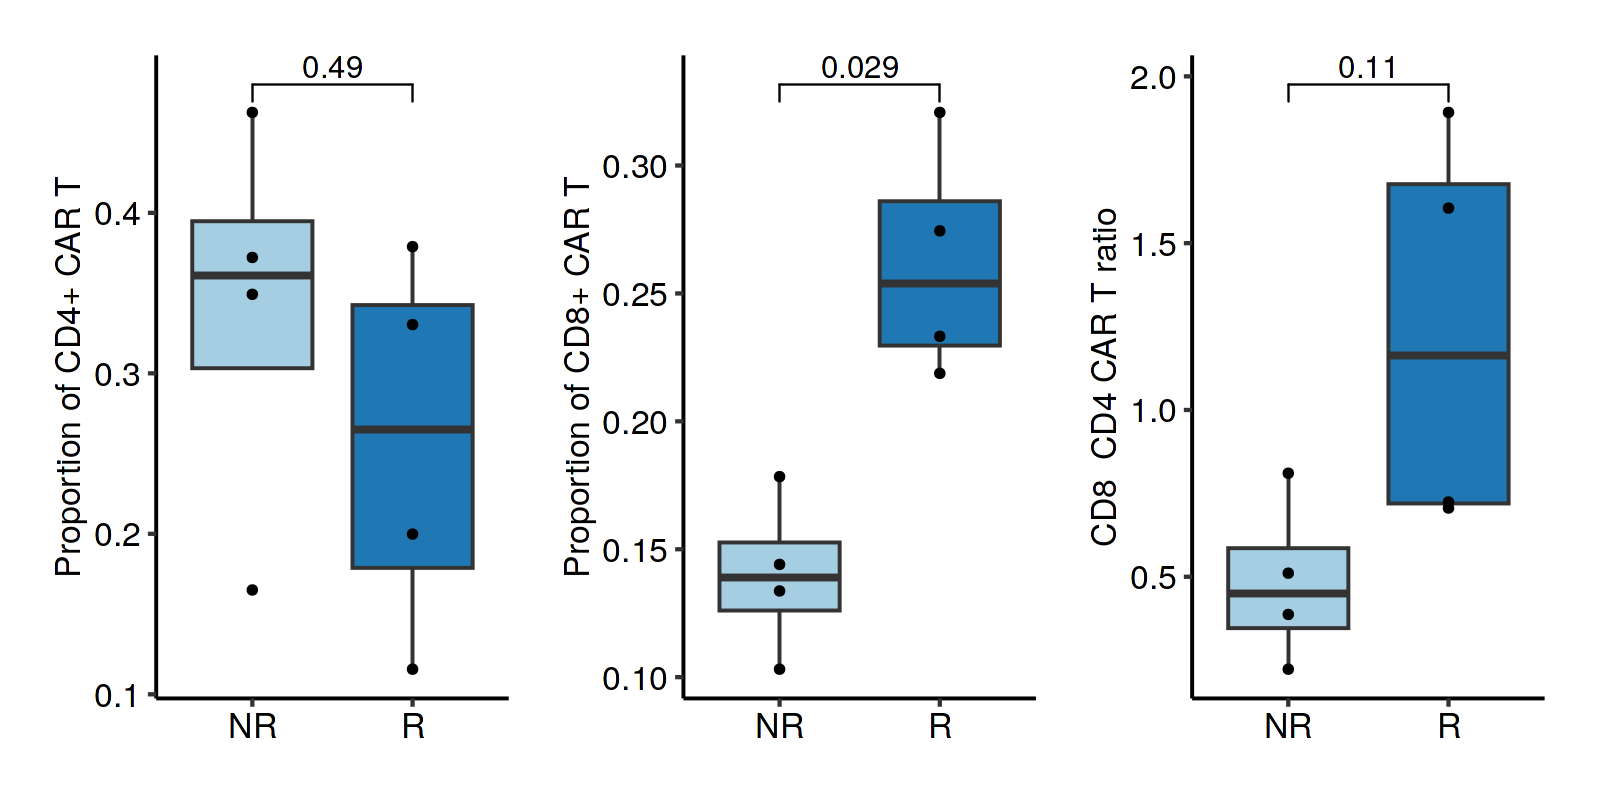

In [7]:
options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 200)
final_fig